In [1]:
%matplotlib inline

## Novelty & Outlier Detection
- outliers: observations that are "far from the others". Outlier detection is known as *unsupervised* anomaly detection.
- novelties: training data is not polluted by outliers; we want to detect *new* observations that are possible outliers. Novelty detection is known as *semi-supervised* anomaly detection.


## Algorithm Comparison - toy 2D dataset
- Each dataset has 15% of samples generated as random uniform noise - this is the param value fed to (OneClassSVM: ```nu```; other algos: ```contamination```). 
- Decision boundaries are shown in black, except for **Local Outlier Factor** (which doesn't have a predict method for new data).
- [OneClassSVM]() is sensitive to outliers - doesn't perform well for outlier detection. It is better suited for novelty detection when the training set is not polluted.
- [Elliptic Envelope]() assumes data is Gaussian and learns an ellipse, so it degrades when the data is not unimodal. It is robust to outliers.
- [Isolation Forest]() and [Local Outlier Factor]() do reasonably well for multi-modal datasets.
- Model parameters have been hand-picked - need to be adjusted in real practice. The lack of labeled data means this is a challenge.

In [2]:
import time

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [3]:
n_samples         = 300
outliers_fraction = 0.15
n_outliers        = int(outliers_fraction * n_samples)
n_inliers         = n_samples - n_outliers

anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination = outliers_fraction)),
    
    ("One-Class SVM",     svm.OneClassSVM(nu = outliers_fraction, 
                                          kernel = "rbf",
                                          gamma = 0.1)),
    
    ("Isolation Forest", IsolationForest(contamination = outliers_fraction,
                                         random_state = 42)),
    
    ("Local Outlier Factor", LocalOutlierFactor(n_neighbors = 35, 
                                                contamination = outliers_fraction))]

# Define datasets
blobs_params = dict(random_state=0,  
                    n_samples=n_inliers, 
                    n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], 
               cluster_std=0.5,
               **blobs_params)[0],
    
    make_blobs(centers=[[2, 2], [-2, -2]], 
               cluster_std=[0.5, 0.5],
               **blobs_params)[0],

    make_blobs(centers=[[2, 2], [-2, -2]], 
               cluster_std=[1.5, .3],
               **blobs_params)[0],

    4. * (make_moons(n_samples = n_samples, 
                     noise     = .05, 
                     random_state=0)[0] - np.array([0.5, 0.25])),

    14. * (np.random.RandomState(42).rand(n_samples, 2) - 0.5)]

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 150),
                     np.linspace(-7, 7, 150))

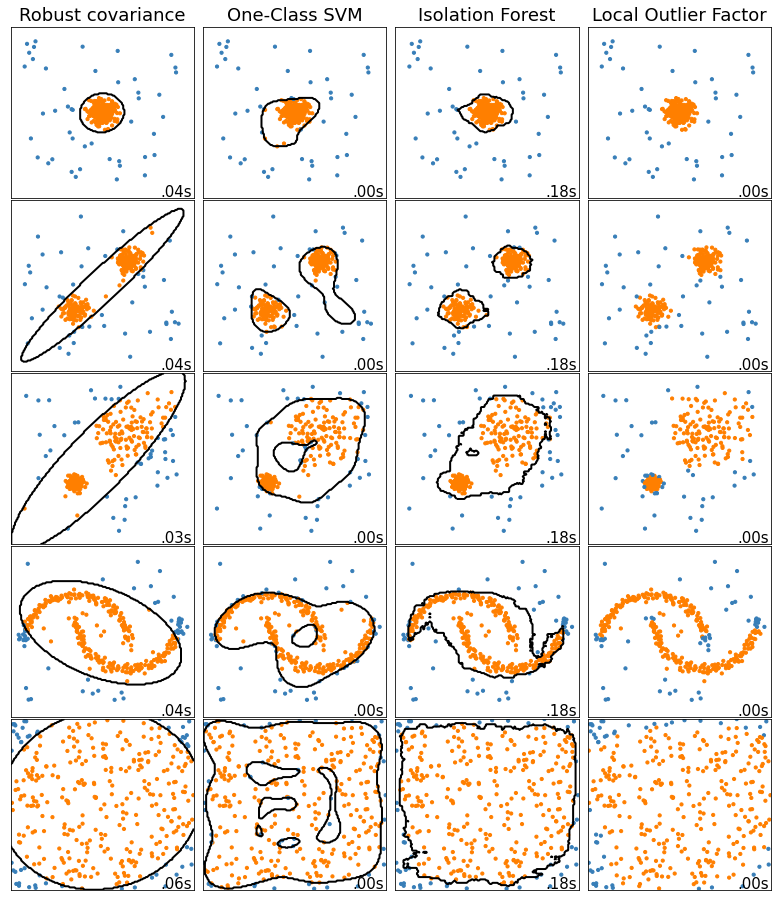

In [6]:
plt.figure(figsize=(len(anomaly_algorithms) * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)
plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(datasets):
    # Add outliers
    X = np.concatenate([X, rng.uniform(low=-6, high=6,
                       size=(n_outliers, 2))], axis=0)

    for name, algorithm in anomaly_algorithms:
        
        t0 = time.time(); algorithm.fit(X); t1 = time.time()
        
        plt.subplot(len(datasets), 
                    len(anomaly_algorithms), 
                    plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit(X).predict(X)

        # plot the levels lines and the points
        if name != "Local Outlier Factor":  # LOF does not implement predict
            Z = algorithm.predict(np.c_[xx.ravel(), 
                                        yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, 
                        levels=[0], linewidths=2, colors='black')

        colors = np.array(['#377eb8', '#ff7f00'])
        plt.scatter(X[:, 0], 
                    X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, 
                 ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, 
                 size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

## Novelty Detection with [OneClassSVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM)
- Given a dataset of _n_ observations across _p_ features, all from the same distribution. 
- **OneClassSVM** is used by Support Vector Machines. It requires a kernel (typically **RBF**) and a scalar param to define a frontier. The _v_ param (aka "margin") corresponds to the probability of finding a new observation outside the frontier.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm

xx, yy = np.meshgrid(np.linspace(-5, 5, 500), 
                     np.linspace(-5, 5, 500))

# Generate train data
X       = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X       = 0.3 * np.random.randn(20, 2)
X_test  = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, 
                               high=4, 
                               size=(20, 2))

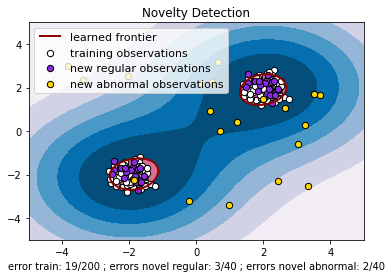

In [9]:
# fit the model
clf = svm.OneClassSVM(nu     = 0.1, 
                      kernel = "rbf", 
                      gamma  = 0.1)
clf.fit(X_train)

y_pred_train     = clf.predict(X_train)
y_pred_test      = clf.predict(X_test)
y_pred_outliers  = clf.predict(X_outliers)
n_error_train    = y_pred_train[y_pred_train == -1].size
n_error_test     = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, 
             levels = np.linspace(Z.min(), 0, 7), 
             cmap = plt.cm.PuBu)

a = plt.contour(xx, yy, Z, 
                levels = [0], 
                linewidths = 2, colors = 'darkred')

plt.contourf(xx, yy, Z, 
             levels = [0, Z.max()], 
             colors='palevioletred')

s = 40
b1 = plt.scatter(X_train[:, 0], 
                 X_train[:, 1], 
                 c='white', s=s, edgecolors='k')

b2 = plt.scatter(X_test[:, 0], 
                 X_test[:, 1], 
                 c='blueviolet', s=s, edgecolors='k')

c = plt.scatter(X_outliers[:, 0], 
                X_outliers[:, 1], 
                c='gold', s=s, edgecolors='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "error train: %d/200 ; errors novel regular: %d/40 ; "
    "errors novel abnormal: %d/40"
    % (n_error_train, n_error_test, n_error_outliers))
plt.show()

## Outlier detection with [Elliptic Envelope](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope)
- Sometimes you don't have a clean dataset.
- Outlier detection assumes that "clean" data comes from a known distribution - from which we can define the "shape" of the data. 
- Elliptic Envelope fits a robust covariance estimate to the data - thus fitting an ellipse to the central data points.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import EmpiricalCovariance, MinCovDet

n_samples = 125
n_outliers = 25
n_features = 2

# generate data
gen_cov       = np.eye(n_features)
gen_cov[0, 0] = 2.
X             = np.dot(np.random.randn(n_samples, n_features), 
                       gen_cov)
# add some outliers
outliers_cov = np.eye(n_features)
outliers_cov[np.arange(1, n_features), 
             np.arange(1, n_features)] = 7.

X[-n_outliers:] = np.dot(np.random.randn(n_outliers, n_features), 
                         outliers_cov)

# fit a Minimum Covariance Determinant (MCD) robust estimator to data
# compare estimators learnt from the full data set with true parameters

robust_cov = MinCovDet().fit(X)
emp_cov    = EmpiricalCovariance().fit(X)

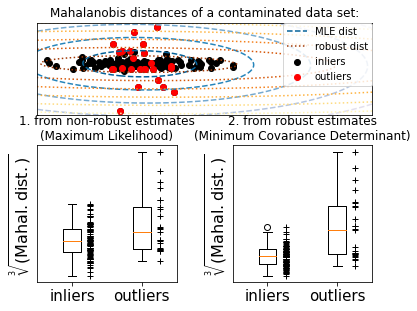

In [15]:
# Display results
fig = plt.figure()
plt.subplots_adjust(hspace=-.1, wspace=.4, top=.95, bottom=.05)

# Show data set
subfig1 = plt.subplot(3, 1, 1)
inlier_plot = subfig1.scatter(X[:, 0], X[:, 1],
                              color='black', label='inliers')
outlier_plot = subfig1.scatter(X[:, 0][-n_outliers:], X[:, 1][-n_outliers:],
                               color='red', label='outliers')
subfig1.set_xlim(subfig1.get_xlim()[0], 11.)
subfig1.set_title("Mahalanobis distances of a contaminated data set:")

# Show contours of the distance functions
xx, yy = np.meshgrid(np.linspace(plt.xlim()[0], plt.xlim()[1], 100),
                     np.linspace(plt.ylim()[0], plt.ylim()[1], 100))
zz = np.c_[xx.ravel(), yy.ravel()]

mahal_emp_cov = emp_cov.mahalanobis(zz)
mahal_emp_cov = mahal_emp_cov.reshape(xx.shape)
emp_cov_contour = subfig1.contour(xx, yy, np.sqrt(mahal_emp_cov),
                                  cmap=plt.cm.PuBu_r,
                                  linestyles='dashed')

mahal_robust_cov = robust_cov.mahalanobis(zz)
mahal_robust_cov = mahal_robust_cov.reshape(xx.shape)
robust_contour = subfig1.contour(xx, yy, np.sqrt(mahal_robust_cov),
                                 cmap=plt.cm.YlOrBr_r, linestyles='dotted')

subfig1.legend([emp_cov_contour.collections[1], robust_contour.collections[1],
                inlier_plot, outlier_plot],
               ['MLE dist', 'robust dist', 'inliers', 'outliers'],
               loc="upper right", borderaxespad=0)
plt.xticks(())
plt.yticks(())

# Plot the scores for each point
emp_mahal = emp_cov.mahalanobis(X - np.mean(X, 0)) ** (0.33)
subfig2 = plt.subplot(2, 2, 3)
subfig2.boxplot([emp_mahal[:-n_outliers], emp_mahal[-n_outliers:]], widths=.25)
subfig2.plot(np.full(n_samples - n_outliers, 1.26),
             emp_mahal[:-n_outliers], '+k', markeredgewidth=1)
subfig2.plot(np.full(n_outliers, 2.26),
             emp_mahal[-n_outliers:], '+k', markeredgewidth=1)
subfig2.axes.set_xticklabels(('inliers', 'outliers'), size=15)
subfig2.set_ylabel(r"$\sqrt[3]{\rm{(Mahal. dist.)}}$", size=16)
subfig2.set_title("1. from non-robust estimates\n(Maximum Likelihood)")
plt.yticks(())

robust_mahal = robust_cov.mahalanobis(X - robust_cov.location_) ** (0.33)
subfig3 = plt.subplot(2, 2, 4)
subfig3.boxplot([robust_mahal[:-n_outliers], robust_mahal[-n_outliers:]],
                widths=.25)
subfig3.plot(np.full(n_samples - n_outliers, 1.26),
             robust_mahal[:-n_outliers], '+k', markeredgewidth=1)
subfig3.plot(np.full(n_outliers, 2.26),
             robust_mahal[-n_outliers:], '+k', markeredgewidth=1)
subfig3.axes.set_xticklabels(('inliers', 'outliers'), size=15)
subfig3.set_ylabel(r"$\sqrt[3]{\rm{(Mahal. dist.)}}$", size=16)
subfig3.set_title("2. from robust estimates\n(Minimum Covariance Determinant)")
plt.yticks(())

plt.show()

## Outlier detection with [Isolation Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest)
- Random Forests are another way of id'ing outliers. Isolation Forest works by randomly selecting features, then randomly selecting a split value between that feature's min & max values.
- Recursiv partioning uses a tree structure. The #splits required to isolate a sample equates to root-termination path length. This length is a measure of normality and a decision function.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)

# Generate train data
X = 0.3 * rng.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

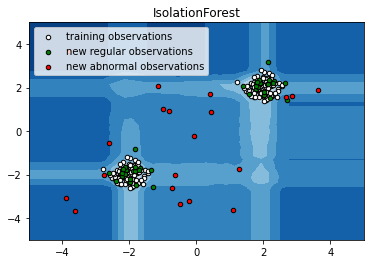

In [17]:
plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white',
                 s=20, edgecolor='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green',
                 s=20, edgecolor='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red',
                s=20, edgecolor='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2, c],
           ["training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left")
plt.show()

## Outlier detection with [Local Outlier Factor (LOF)](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor)
- LOF measures a local density deviation of a data point vs its neighbors. The idea is to detect samples that have substantially lower density than its neighbors.
- Local density is, in practice, obtained from KNN.
- LOF does not provide ```predict```,```'decision_function``` or ```score_samples``` methods - only a ```fit_predict``` method. It does also provide an abnormality score vi ```negative_outlier_factor```.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

In [19]:
np.random.seed(42)

# Generate train data
X_inliers = 0.3 * np.random.randn(100, 2)
X_inliers = np.r_[X_inliers + 2, 
                  X_inliers - 2]

# Generate some outliers
X_outliers = np.random.uniform(low=-4, 
                               high=4, 
                               size=(20, 2))
X = np.r_[X_inliers, 
          X_outliers]

n_outliers   = len(X_outliers)
ground_truth = np.ones(len(X), dtype=int)
ground_truth[-n_outliers:] = -1

# fit the model for outlier detection (default)
clf = LocalOutlierFactor(n_neighbors=20, 
                         contamination=0.1)

# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).

y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_

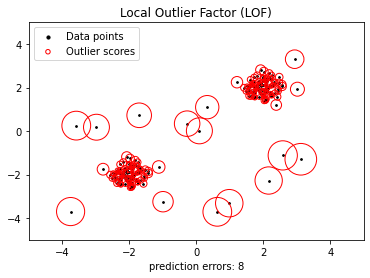

In [21]:
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color='k', s=3., label='Data points')

# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
    
plt.scatter(X[:, 0], 
            X[:, 1], 
            s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')

plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

## Novelty Detection with [Local Outlier Factor (LOF)](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor)
- To use LOF for novelty detection (label prediction, abnormality scores, ...), create an estimator with ```novelty=True```.
- When you do this, you can only use ```predict```,```decision_function``` and ```score_samples``` on new unseen data - not on training samples. Otherwise you will get incorrect data. Abnormality scores are available via ```negative_outlier_factor_```.